# Model to process an aadhar card image.
## 1.) Identifying aadhar number of an Image with noise
## 2.) Validating aadhar number
## 3.) Masking the aadhar number

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pytesseract
from IPython.display import Image
from pytesseract import Output

In [3]:
image = cv2.imread('img.jpg')

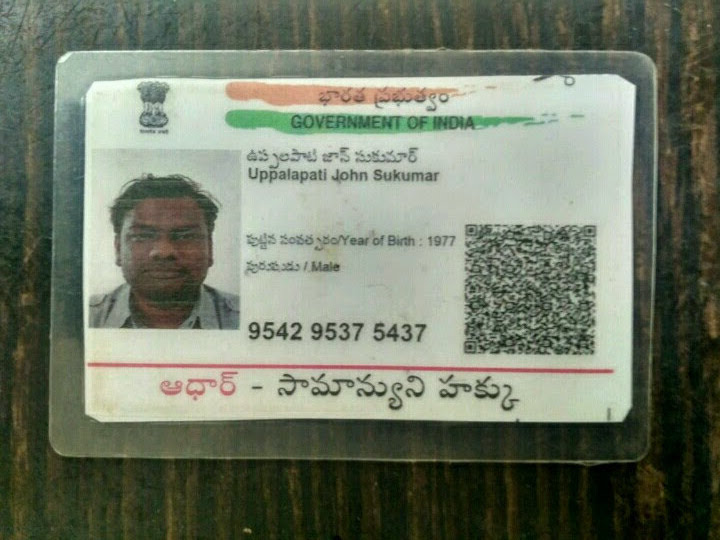

In [4]:
new_image = np.zeros(image.shape, image.dtype)
Image(filename='img.jpg') 

### Adjusting brightness and contrast

In [5]:
alpha = 1.1  #Adjustment factor for Contrast
beta = -30   # Adjustment factor for Brightness

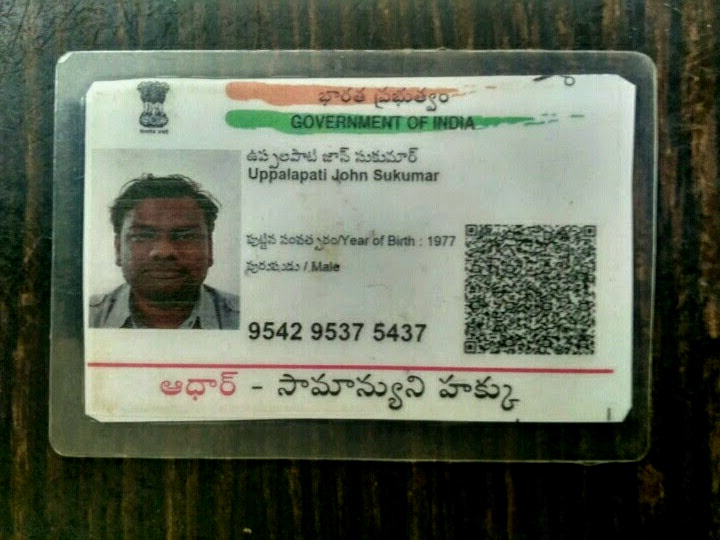

In [6]:

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
cv2.imwrite('processed.jpg',new_image)
Image(filename='processed.jpg') 

### Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [7]:

img = cv2.imread('processed.jpg',0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
cv2.imwrite('clahe_2.jpg',cl1)

True

### Broadening the characters in case required.

In [8]:
#kernel = np.ones((5,5),np.uint8)
#erosion = cv2.erode(img,kernel,iterations = 1)
#cv2.imwrite('eroded.jpg',erosion)

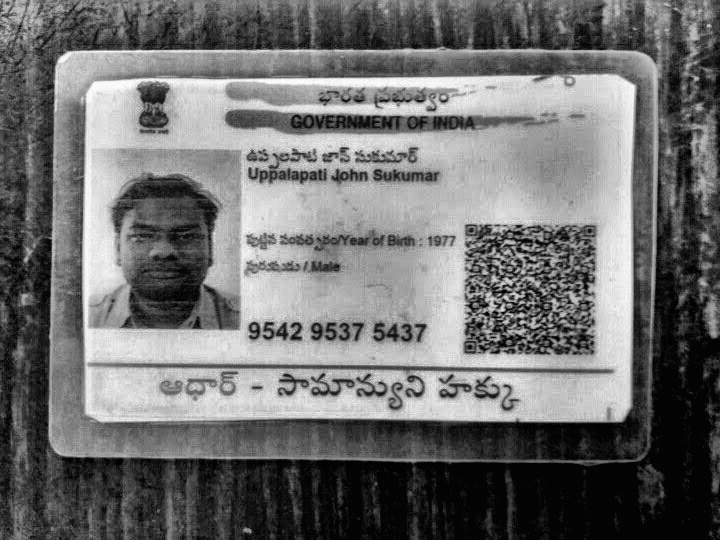

In [9]:
Image(filename='clahe_2.jpg') 

### Removing Noise

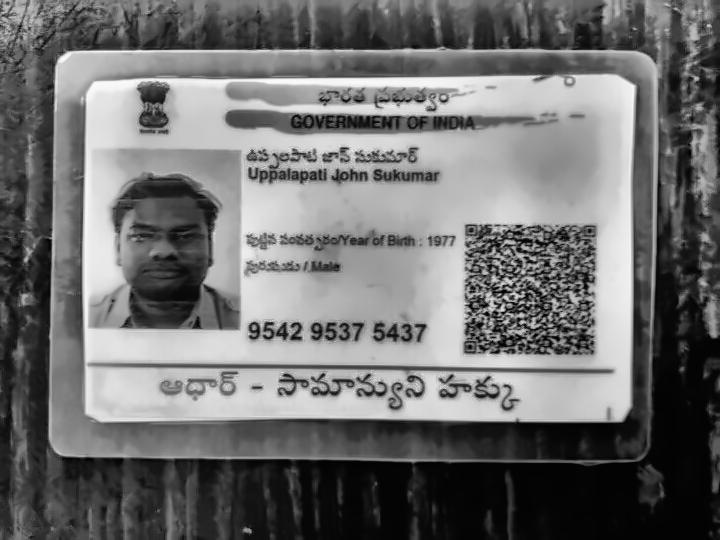

In [10]:
img = cv2.imread('clahe_2.jpg')
dst = cv2.fastNlMeansDenoising(img,10,10,7,21)
cv2.imwrite('final.png',dst)
Image(filename='final.png') 

### Converthing it into binary shade of black and white

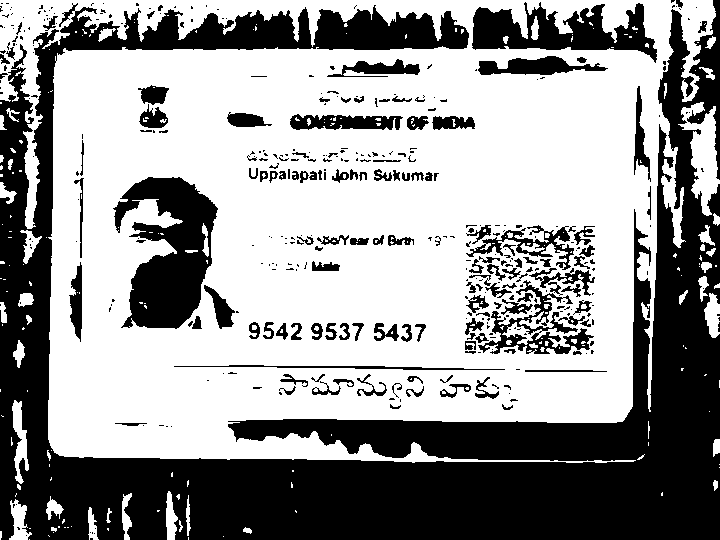

In [11]:
from PIL import Image as Img
img = Img.open('final.png')
img = img.convert('RGBA')
pix = img.load()
for y in range(img.size[1]):
    for x in range(img.size[0]):
        if pix[x, y][0] < 82 or pix[x, y][1] < 82 or pix[x, y][2] < 82:
            pix[x, y] = (0, 0, 0, 255)
        else:
            pix[x, y] = (255, 255, 255, 255)

img.save('temp.png')
Image(filename='temp.png') 

In [12]:
text = pytesseract.image_to_string(Img.open('temp.png'))
print(text)

ve jeter +
 GOVERMENT OF BEA

sine
kumar

LX

~~ SSrsoe

9542 9537 5437


In [13]:
uid = ''
try:
    newlist = []
    for xx in text.split('\n'):
        newlist.append(xx)
    for newL in newlist:
        print(newL)
    for no in newL:
        for character in no:
            if character.isdigit():
                uid+=character

except Exception:
    pass



ve jeter +
 GOVERMENT OF BEA

sine
kumar

LX

~~ SSrsoe

9542 9537 5437


In [14]:
print("The UID of the aadhar card is: ",uid);

The UID of the aadhar card is:  954295375437


## Validation of aadhar number using Verhoeff Algorithm

In [15]:
verhoeff_table_d = (
    (0,1,2,3,4,5,6,7,8,9),
    (1,2,3,4,0,6,7,8,9,5),
    (2,3,4,0,1,7,8,9,5,6),
    (3,4,0,1,2,8,9,5,6,7),
    (4,0,1,2,3,9,5,6,7,8),
    (5,9,8,7,6,0,4,3,2,1),
    (6,5,9,8,7,1,0,4,3,2),
    (7,6,5,9,8,2,1,0,4,3),
    (8,7,6,5,9,3,2,1,0,4),
    (9,8,7,6,5,4,3,2,1,0))
verhoeff_table_p = (
    (0,1,2,3,4,5,6,7,8,9),
    (1,5,7,6,2,8,3,0,9,4),
    (5,8,0,3,7,9,6,1,4,2),
    (8,9,1,6,0,4,3,5,2,7),
    (9,4,5,3,1,2,6,8,7,0),
    (4,2,8,6,5,7,3,9,0,1),
    (2,7,9,3,8,0,6,4,1,5),
    (7,0,4,6,9,1,3,2,5,8))
verhoeff_table_inv = (0,4,3,2,1,5,6,7,8,9)

In [16]:
def checksum(number):
    """For a given number generates a Verhoeff digit and
    returns number + digit"""
    c = 0
    for i, item in enumerate(reversed(str(number))):
        c = verhoeff_table_d[c][verhoeff_table_p[i % 8][int(item)]]
    return c

In [17]:
if checksum(uid)== 0:
    print("The UID of the aadhar is valid !")
else:
    print("The UID of the aadhar is invalid !")

The UID of the aadhar is valid !


## Masking the UID

In [31]:
img = cv2.imread('temp.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT, lang='eng')
n_boxes = len(d['level'])

In [56]:
original = cv2.imread('img.jpg')
overlay = original.copy()
num = uid[:4]
for i in range(n_boxes):
    text = d['text'][i]
    if text == num:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        (x1, y1, w1, h1) = (d['left'][i + 1], d['top'][i + 1], d['width'][i + 1], d['height'][i + 1])
        (x2, y2, w2, h2) = (d['left'][i + 2], d['top'][i + 2], d['width'][i + 2], d['height'][i + 2])
        # cv2.rectangle(img, (x, y), (x1 + w1, y1 + h1), (0, 255, 0), 2)
        cv2.rectangle(overlay, (x, y), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # cv2.rectangle(img, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 2)
        cv2.rectangle(overlay, (x2, y2), (x2 + w2, y2 + h2), (0, 0, 0), -1)
        # print(text)

In [63]:
alpha = 1  # Transparency factor.
# Following line overlays transparent rectangle over the image
img_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

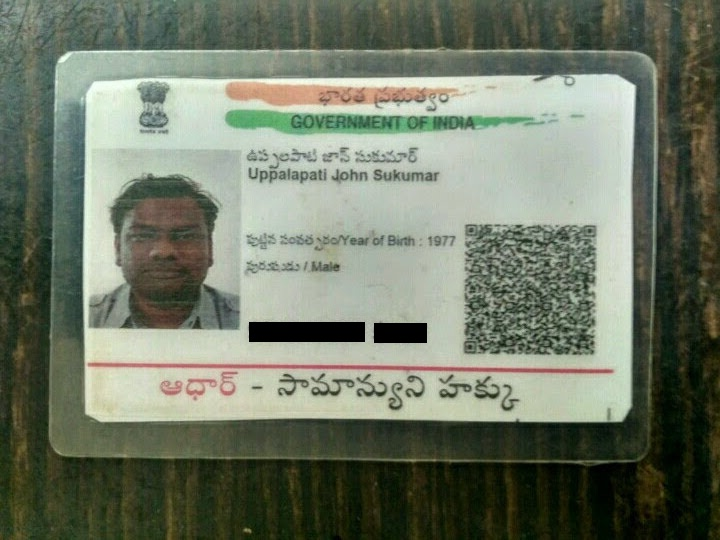

In [67]:
cv2.imwrite('final.jpg',img_new)
Image(filename='final.jpg') 